In [83]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from keras.src.engine.data_adapter import train_validation_split
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Image

import os
import os.path
import mediapipe as mp
import cv2
from tensorflow_estimator.python.estimator.canned.timeseries.saved_model_utils import predict_continuation

In [2]:
%matplotlib notebook

In [25]:
df = pd.read_csv("D:\Documents\GitHub\CIR\emotion_classification\data\emotion_dataset\\train\\neutral_data\im0.png.csv", sep=';', usecols=[2,3,4])

df.head()

,x,y,z
0,0.515589,0.788926,-0.088295
1,0.518680,0.654209,-0.189039
2,0.513163,0.689541,-0.092640
3,0.482660,0.521265,-0.153718
4,0.518945,0.614830,-0.204103


In [26]:
# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['x'], df['y'], df['z'])

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

<IPython.core.display.Javascript object>

Text(0.5, 0, 'Z')

# Load Data from csv's

THE HAPPY CLASS CONTAINS TWICE AS MUCH FILES AS THE NEUTRAL CLASS!
MAYBE THIS HAS TO BE CHANGED FOR THE MODEL TO WORK CORRECTLY

In [148]:
AMOUNT_OF_FEATURES = 468
AMOUNT_OF_FILES = 0

df = pd.DataFrame(dtype=float)

# classes = ["non_smile_data", "smile_data"]
# for c in classes:
#     for dirpath, dirnames, filenames in os.walk(f"D:\Documents\GitHub\CIR\emotion_classification\data\smile_dataset\\{c}"):
#          for filename in filenames:
#             file_path = dirpath + "\\" + filename
#             df_new = pd.read_csv(file_path, sep=";", usecols=[0,2,3,4])
#             df = pd.concat([df, df_new])
#             AMOUNT_OF_FILES += 1

classes = ["neutral_data", "happy_data"]
for c in classes:
    for dirpath, dirnames, filenames in os.walk(f"D:\Documents\GitHub\CIR\emotion_classification\data\emotion_dataset\\train\\{c}"):
         for filename in filenames[:4900]:
            file_path = dirpath + "\\" + filename
            df_new = pd.read_csv(file_path, sep=";", usecols=[0,2,3,4])
            df = pd.concat([df, df_new])
            AMOUNT_OF_FILES += 1
            if AMOUNT_OF_FILES % 1000 == 0:
                print(f"{AMOUNT_OF_FILES} done!")

print(df)
print((AMOUNT_OF_FEATURES, AMOUNT_OF_FILES))

         Class         x         y         z
0    non_smile  0.515589  0.788926 -0.088295
1    non_smile  0.518680  0.654209 -0.189039
2    non_smile  0.513163  0.689541 -0.092640
3    non_smile  0.482660  0.521265 -0.153718
4    non_smile  0.518945  0.614830 -0.204103
..         ...       ...       ...       ...
463      smile  0.566141  0.419585  0.013681
464      smile  0.551687  0.424158 -0.005425
465      smile  0.543770  0.428016 -0.026534
466      smile  0.707941  0.422088  0.038870
467      smile  0.726682  0.408990  0.041713

[4535856 rows x 4 columns]
(468, 9692)


In [149]:
X = df[['x', 'y', 'z']].values
Y = df['Class'].values

X = X.reshape(int(np.size(X) / (AMOUNT_OF_FEATURES * 3)), AMOUNT_OF_FEATURES, 3)
print(np.shape(X))

Y = Y[np.arange(0, np.size(Y), AMOUNT_OF_FEATURES)]
Y = np.where(Y == "non_smile", 0, 1)
print(np.shape(Y))

(9692, 468, 3)
(9692,)


In [150]:
s = np.arange(X.shape[0])
np.random.shuffle(s)
X = X[s]
Y = Y[s]
print(np.shape(X))
print(np.shape(Y))

(9692, 468, 3)
(9692,)


# Construct model

In [164]:
model = models.Sequential()
model.add(layers.Conv1D(16, 3, activation='relu', input_shape=(AMOUNT_OF_FEATURES, 3)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(64, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))

In [165]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_43 (Conv1D)          (None, 466, 16)           160       
                                                                 
 max_pooling1d_43 (MaxPooli  (None, 233, 16)           0         
 ng1D)                                                           
                                                                 
 conv1d_44 (Conv1D)          (None, 231, 32)           1568      
                                                                 
 max_pooling1d_44 (MaxPooli  (None, 115, 32)           0         
 ng1D)                                                           
                                                                 
 conv1d_45 (Conv1D)          (None, 113, 64)           6208      
                                                                 
 max_pooling1d_45 (MaxPooli  (None, 56, 64)          

In [166]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [175]:
# Training loop
history = model.fit(X, Y, epochs=50, validation_split=0.2)

# Print history (optional)
# print(history.history)

Epoch 1/50
243/243 [==============================] - 7s 29ms/step - loss: 0.2494 - accuracy: 0.9058 - val_loss: 0.2752 - val_accuracy: 0.8917
Epoch 2/50
243/243 [==============================] - 8s 31ms/step - loss: 0.2525 - accuracy: 0.9046 - val_loss: 0.2704 - val_accuracy: 0.8927
Epoch 3/50
243/243 [==============================] - 5s 21ms/step - loss: 0.2505 - accuracy: 0.9042 - val_loss: 0.2654 - val_accuracy: 0.8969
Epoch 4/50
243/243 [==============================] - 5s 20ms/step - loss: 0.2465 - accuracy: 0.9078 - val_loss: 0.2669 - val_accuracy: 0.8922
Epoch 5/50
243/243 [==============================] - 5s 19ms/step - loss: 0.2461 - accuracy: 0.9067 - val_loss: 0.2979 - val_accuracy: 0.8829
Epoch 6/50
243/243 [==============================] - 5s 20ms/step - loss: 0.2471 - accuracy: 0.9091 - val_loss: 0.2623 - val_accuracy: 0.8938
Epoch 7/50
243/243 [==============================] - 5s 20ms/step - loss: 0.2474 - accuracy: 0.9057 - val_loss: 0.2668 - val_accuracy: 0.8963

In [176]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
AMOUNT_OF_FEATURES = 468
AMOUNT_OF_FILES = 0

df_test = pd.DataFrame(dtype=float)

# classes = ["non_smile_data", "smile_data"]
# for c in classes:
#     for dirpath, dirnames, filenames in os.walk(f"D:\Documents\GitHub\CIR\emotion_classification\data\smile_dataset\\{c}"):
#          for filename in filenames:
#             file_path = dirpath + "\\" + filename
#             df_new = pd.read_csv(file_path, sep=";", usecols=[0,2,3,4])
#             df = pd.concat([df, df_new])
#             AMOUNT_OF_FILES += 1

classes = ["neutral_data", "happy_data"]
for c in classes:
    for dirpath, dirnames, filenames in os.walk(f"D:\Documents\GitHub\CIR\emotion_classification\data\emotion_dataset\\test\\{c}"):
         for filename in filenames:
            file_path = dirpath + "\\" + filename
            df_new = pd.read_csv(file_path, sep=";", usecols=[0,2,3,4])
            df_test = pd.concat([df_test, df_new])
            AMOUNT_OF_FILES += 1

print(df_test)
print((AMOUNT_OF_FEATURES, AMOUNT_OF_FILES))

         Class         x         y         z
0    non_smile  0.529245  0.766202 -0.070398
1    non_smile  0.562616  0.647328 -0.194880
2    non_smile  0.542791  0.675010 -0.088586
3    non_smile  0.537037  0.508092 -0.175326
4    non_smile  0.569438  0.609401 -0.214363
..         ...       ...       ...       ...
463      smile  0.555455  0.339415 -0.009435
464      smile  0.546120  0.353151 -0.029167
465      smile  0.543636  0.363681 -0.051784
466      smile  0.682788  0.264544  0.021749
467      smile  0.692637  0.247412  0.024002

[1353456 rows x 4 columns]
(468, 2892)


In [103]:
X_test = df_test[['x', 'y', 'z']].values
Y_test = df_test['Class'].values

X_test = X_test.reshape(int(np.size(X_test) / (AMOUNT_OF_FEATURES * 3)), AMOUNT_OF_FEATURES, 3)
print(np.shape(X_test))

Y_test = Y_test[np.arange(0, np.size(Y_test), AMOUNT_OF_FEATURES)]
Y_test = np.where(Y_test == "non_smile", 0, 1)
print(np.shape(Y_test))

(2892, 468, 3)
(2892,)


In [177]:
results = model.evaluate(X_test, Y_test)
print("test loss, test acc:", results)

91/91 [==============================] - 1s 6ms/step - loss: 0.2759 - accuracy: 0.8970
test loss, test acc: [0.27585601806640625, 0.8969570994377136]


In [43]:
mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh

def extract_face_landmarks(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    with mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5) as face_mesh:
        results = face_mesh.process(image_rgb)
        if results.multi_face_landmarks:
          landmarks = results.multi_face_landmarks[0].landmark
        else:
          return None
    return landmarks

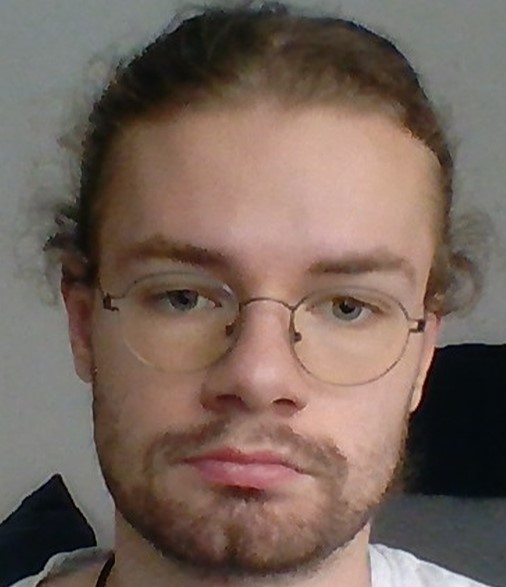

1/1 [==============================] - 0s 36ms/step
neutral
Difference: 1.963536024093628


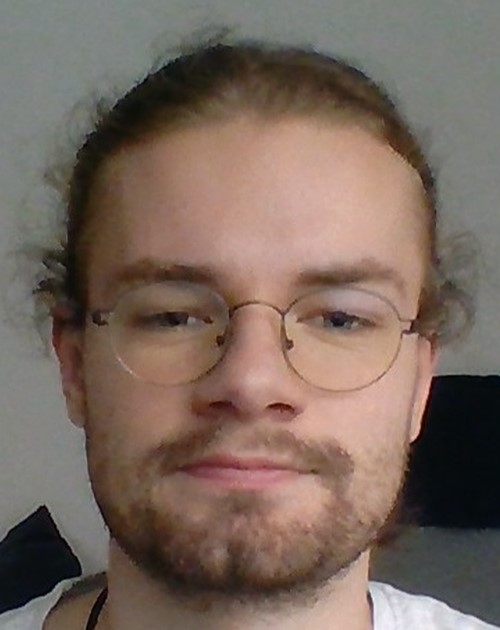

1/1 [==============================] - 0s 24ms/step
happy
Difference: 0.42579829692840576


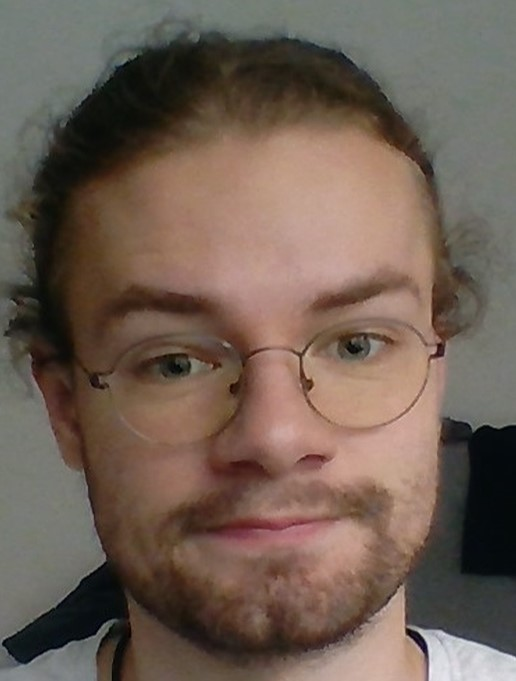

1/1 [==============================] - 0s 24ms/step
happy
Difference: 2.229611396789551


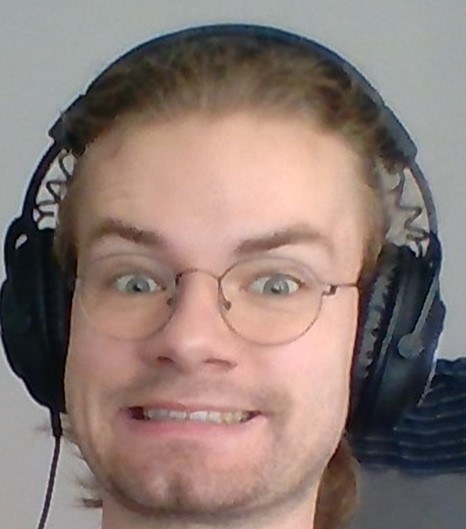

1/1 [==============================] - 0s 25ms/step
happy
Difference: 3.8604555130004883


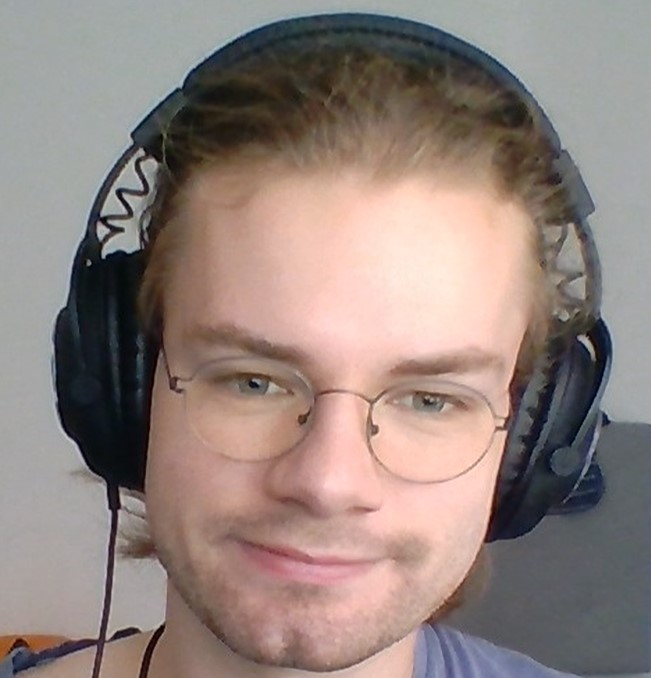

1/1 [==============================] - 0s 21ms/step
happy
Difference: 1.1678475141525269


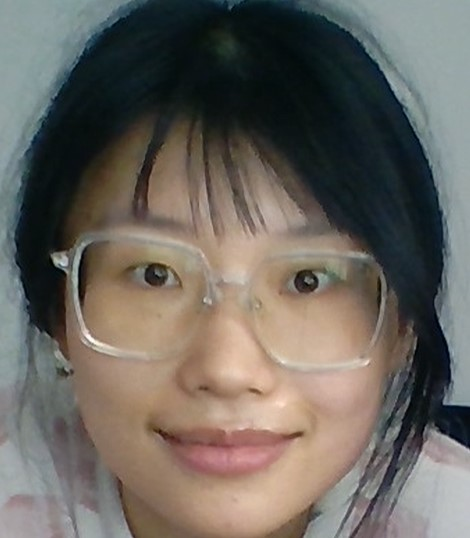

1/1 [==============================] - 0s 21ms/step
happy
Difference: 2.918473243713379


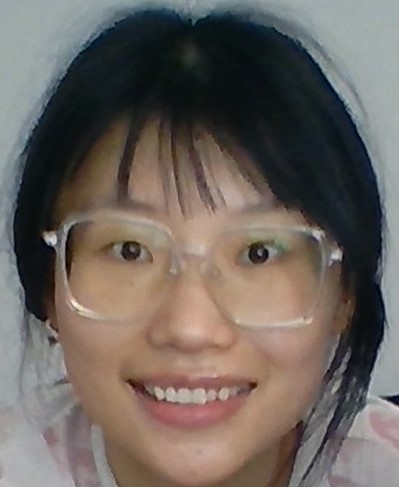

1/1 [==============================] - 0s 24ms/step
happy
Difference: 5.244620323181152


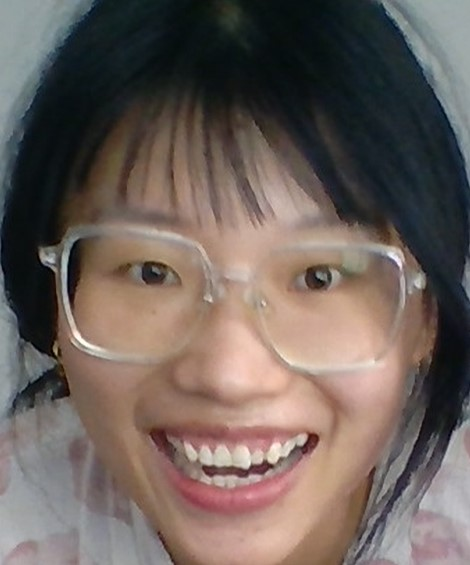

1/1 [==============================] - 0s 25ms/step
happy
Difference: 6.055459976196289


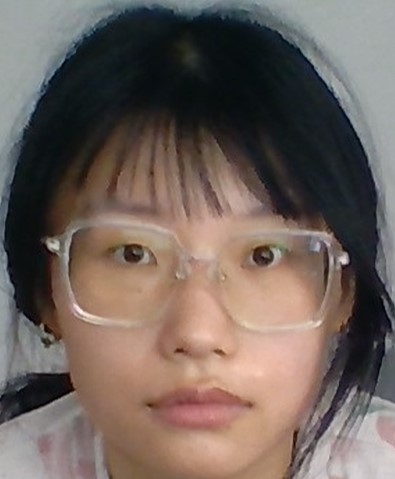

1/1 [==============================] - 0s 21ms/step
neutral
Difference: 1.4768385887145996


In [183]:
self_test = [
    "D:\Documents\GitHub\CIR\emotion_classification\data\own_data\\neutral.jpg",
     "D:\Documents\GitHub\CIR\emotion_classification\data\own_data\\slightsmile.jpg",
     "D:\Documents\GitHub\CIR\emotion_classification\data\own_data\\smile.jpg",
     "D:\Documents\GitHub\CIR\emotion_classification\data\own_data\\opensmile.jpg",
     "D:\Documents\GitHub\CIR\emotion_classification\data\own_data\\natsmile.jpg",
     "D:\Documents\GitHub\CIR\emotion_classification\data\own_data\\smile1.jpg",
     "D:\Documents\GitHub\CIR\emotion_classification\data\own_data\\smile2.jpg",
     "D:\Documents\GitHub\CIR\emotion_classification\data\own_data\\smile3.jpg",
     "D:\Documents\GitHub\CIR\emotion_classification\data\own_data\\neutralgloria.jpg"
]

for test in self_test:
    x, y, z = [], [], []
    landmarks = extract_face_landmarks(test)
    display(Image(filename=test))
    for i, landmark in enumerate(landmarks):
        x.append(landmark.x)
        y.append(landmark.y)
        z.append(landmark.z)
    dftest = pd.DataFrame({"x": x, "y": y, "z": z})
    Xtest = dftest[['x', 'y', 'z']].values
    Xtest = Xtest.reshape(int(np.size(Xtest) / (AMOUNT_OF_FEATURES * 3)), AMOUNT_OF_FEATURES, 3)
    predictions = model.predict(Xtest)
    c = np.argmax(predictions, axis=1)
    print(classes[c[0]][:-5])
    print(f"Difference: {np.abs(predictions[0][0] - predictions[0][1])}")
        

In [174]:
model.save("D:\Documents\GitHub\CIR\emotion_classification\model9.keras")

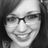

1/1 [==============================] - 0s 17ms/step
happy -> happy
Difference: 3.0052435398101807


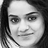

1/1 [==============================] - 0s 36ms/step
happy -> happy
Difference: 2.0492496490478516


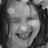

1/1 [==============================] - 0s 20ms/step
happy -> happy
Difference: 5.540572643280029


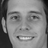

1/1 [==============================] - 0s 24ms/step
happy -> happy
Difference: 2.020460367202759


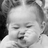

1/1 [==============================] - 0s 29ms/step
happy -> neutral
Difference: 1.104384183883667


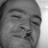

1/1 [==============================] - 0s 21ms/step
happy -> happy
Difference: 0.5820584297180176


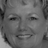

1/1 [==============================] - 0s 22ms/step
happy -> happy
Difference: 2.12604022026062


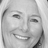

1/1 [==============================] - 0s 21ms/step
happy -> happy
Difference: 4.1715474128723145


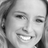

1/1 [==============================] - 0s 235ms/step
happy -> happy
Difference: 5.179427146911621


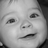

1/1 [==============================] - 0s 17ms/step
happy -> happy
Difference: 1.5169907808303833


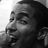

1/1 [==============================] - 0s 17ms/step
happy -> happy
Difference: 0.1427929401397705


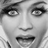

1/1 [==============================] - 0s 25ms/step
happy -> happy
Difference: 0.7802717685699463


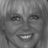

1/1 [==============================] - 0s 28ms/step
happy -> happy
Difference: 4.328190326690674


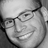

1/1 [==============================] - 0s 22ms/step
happy -> happy
Difference: 6.069197177886963


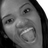

1/1 [==============================] - 0s 21ms/step
happy -> happy
Difference: 6.2778425216674805


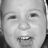

1/1 [==============================] - 0s 21ms/step
happy -> neutral
Difference: 0.10240375995635986


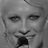

1/1 [==============================] - 0s 22ms/step
happy -> happy
Difference: 1.7898759841918945


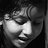

1/1 [==============================] - 0s 21ms/step
happy -> neutral
Difference: 0.4147747755050659


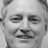

1/1 [==============================] - 0s 23ms/step
happy -> happy
Difference: 1.3009183406829834


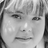

1/1 [==============================] - 0s 22ms/step
neutral -> neutral
Difference: 0.9399825930595398


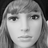

1/1 [==============================] - 0s 22ms/step
neutral -> neutral
Difference: 4.687300205230713


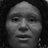

1/1 [==============================] - 0s 23ms/step
neutral -> neutral
Difference: 0.8824344873428345


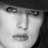

1/1 [==============================] - 0s 24ms/step
neutral -> neutral
Difference: 6.017545700073242


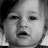

1/1 [==============================] - 0s 20ms/step
neutral -> neutral
Difference: 4.020162105560303


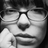

1/1 [==============================] - 0s 25ms/step
neutral -> neutral
Difference: 2.1688852310180664


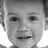

1/1 [==============================] - 0s 35ms/step
neutral -> happy
Difference: 0.4687226414680481


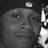

1/1 [==============================] - 0s 24ms/step
neutral -> neutral
Difference: 1.002734661102295


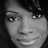

1/1 [==============================] - 0s 39ms/step
neutral -> happy
Difference: 3.0997138023376465


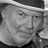

1/1 [==============================] - 0s 24ms/step
neutral -> neutral
Difference: 0.02668452262878418


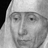

1/1 [==============================] - 0s 24ms/step
neutral -> neutral
Difference: 3.75773549079895


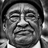

1/1 [==============================] - 0s 24ms/step
neutral -> happy
Difference: 2.189812421798706


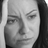

1/1 [==============================] - 0s 35ms/step
neutral -> neutral
Difference: 3.459824562072754


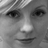

1/1 [==============================] - 0s 20ms/step
neutral -> neutral
Difference: 0.0917060375213623


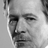

1/1 [==============================] - 0s 21ms/step
neutral -> neutral
Difference: 3.7507317066192627


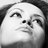

1/1 [==============================] - 0s 18ms/step
neutral -> neutral
Difference: 1.042964220046997


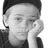

1/1 [==============================] - 0s 24ms/step
neutral -> neutral
Difference: 2.7312350273132324


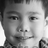

1/1 [==============================] - 0s 19ms/step
neutral -> neutral
Difference: 1.056665062904358


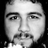

1/1 [==============================] - 0s 19ms/step
neutral -> neutral
Difference: 3.112416982650757


In [202]:
for c in ["happy", "neutral"]:
    for dirpath, dirnames, filenames in os.walk(f"D:\Documents\GitHub\CIR\emotion_classification\data\emotion_dataset\\test\\{c}"):
        for filename in filenames[:20]:
            test_path = dirpath + "/" + filename
            x, y, z = [], [], []
            landmarks = extract_face_landmarks(test_path)
            if landmarks:
                display(Image(filename=test_path))
                for i, landmark in enumerate(landmarks):
                    x.append(landmark.x)
                    y.append(landmark.y)
                    z.append(landmark.z)
                dftest = pd.DataFrame({"x": x, "y": y, "z": z})
                Xtest = dftest[['x', 'y', 'z']].values
                Xtest = Xtest.reshape(int(np.size(Xtest) / (AMOUNT_OF_FEATURES * 3)), AMOUNT_OF_FEATURES, 3)
                predictions = model.predict(Xtest)
                c = np.argmax(predictions, axis=1)
                c_org = dirpath.split('\\')[-1]
                print(f"{c_org} -> {classes[c[0]][:-5]}")
                print(f"Difference: {np.abs(predictions[0][0] - predictions[0][1])}")
        